In [14]:
import os, sys
sys.path.append('../src/')

import seaborn as sns

from scipy import interpolate
from copulae1 import *

import json
with open('../src/configs/BBT_future_Tiingo_xrp_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [15]:
OHR = pd.read_csv("../results/%s/%s/OHR.csv"%(data_name, calibration_method))
cleaned_data = pd.read_csv('../data/cleaned_data/BBT_future_Tiingo_xrp.csv')

In [16]:
norm = stats.norm(0,1)

In [17]:
rs_law = stats.norm(scale = .1)
rf_law = stats.norm(scale = .1)
C = Gaussian({'rho':0.8}, Law_RS=rs_law, Law_RF=rf_law)


C.f_RH(0.7, -0.33)

1.020795194930687e-06

In [18]:
rs_law.ppf(0)

-inf

In [135]:
%%time
h = 1

# M = 1600
# N = 1600 # n points for integration

M = 1+2**10
N = 1+2**10
print(M, N)

u = np.linspace(0.000001,0.999999,N)
u_mat = np.repeat([u], M, axis=0)

y_left  = -0.4
y_right = .4
y_range = y_right - y_left

y = np.linspace(y_left,y_right,M)
y_mat = np.repeat(y.reshape((-1,1)), N, axis=1)

arg1 = norm.ppf(u_mat).reshape(-1)
# arg2 = norm.ppf(rf_law.cdf((rs_law.ppf(u) - y).reshape(-1))/h)

_h = (rs_law.ppf(u_mat) - y_mat)/h
arg2 = rf_law.cdf(_h) 
arg2[arg2 <= 0.000001] = 0.000001
arg2[arg2 >= 0.999999] = 0.999999
arg2 = norm.ppf(arg2).reshape(-1)

arg = np.stack((arg1, arg2), axis=-1)

part1 = (MN.pdf(arg)/(norm.pdf(arg1)*norm.pdf(arg2))).reshape(M,N) # copula density
part2 = rf_law.pdf(_h)

_int = (part1*part2)
# print(_int.shape)

# pdf = (_int[:,1:]+_int[:, :-1])*(1/N)/2
# pdf = np.sum(pdf, axis=1)/h

pdf = integrate.simps(_int, u, axis=1)/np.abs(h)

pdf_fn = interpolate.interp1d(y,pdf,kind='cubic', assume_sorted=True, fill_value="extrapolate")
cdf = np.cumsum(pdf)/np.sum(pdf)
cdf_fn = interpolate.interp1d(y,cdf,kind='cubic', fill_value="extrapolate")

# duplicate_id = (cdf[1:]-cdf[:-1])!=0
# ppf_fn = interpolate.interp1d(cdf[1:][duplicate_id], y[1:][duplicate_id], kind='cubic', fill_value='extrapolate')

ppf_fn = interpolate.interp1d(cdf, y, kind='cubic', fill_value='extrapolate')


VaR5 = -ppf_fn(0.05)
q_arr = np.linspace(0,0.05, 10000)
ES5 = -integrate.simps(ppf_fn(q_arr), q_arr)


print(integrate.simps(pdf,y), cdf[-1])

1025 1025
0.9999862403071154 1.0000000000000004
CPU times: user 966 ms, sys: 185 ms, total: 1.15 s
Wall time: 632 ms


In [136]:
ES5

0.006544954652685093

In [137]:
VaR5

0.10444415804143624

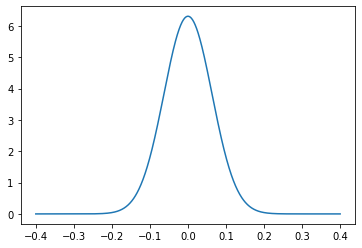

In [119]:
plt.plot(y, pdf)

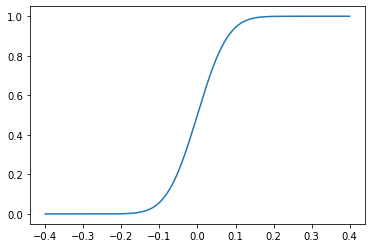

In [120]:
plt.plot(y, cdf)

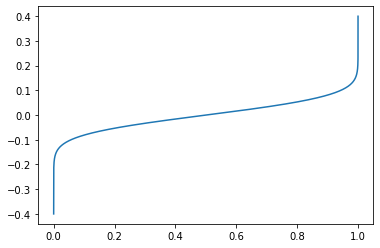

In [127]:

q_arr = np.linspace(0,1, 10000)
plt.plot(q_arr,ppf_fn(q_arr))

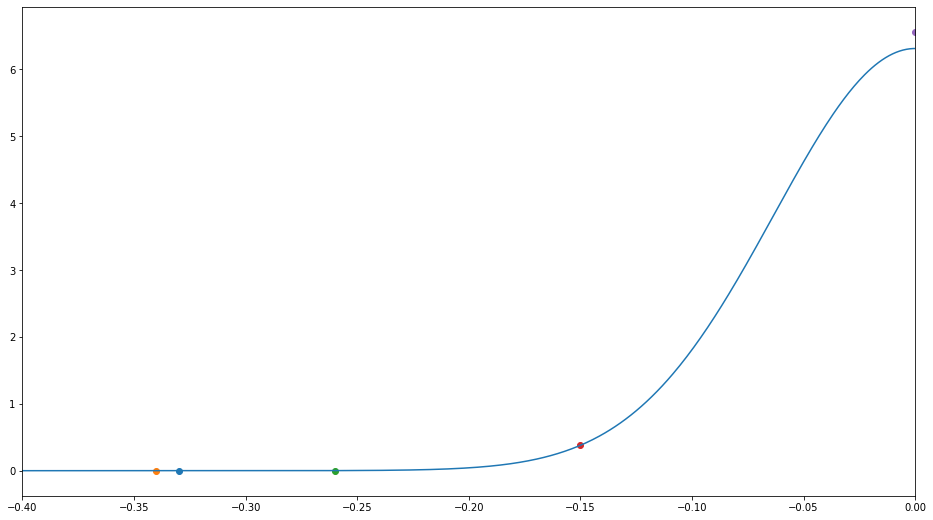

In [101]:
# plt.plot(y, pdf_fn(y))

plt.figure(figsize=(16,9))
plt.plot(y, pdf)

plt.xlim((-0.4,-0))
# x_arr = np.linspace(-0.4,-0.25, 10000)

# plt.plot(x_arr, pdf_fn(x_arr))

plt.scatter(-0.33,C.f_RH(h, -0.33))
plt.scatter(-0.34,C.f_RH(h, -0.34))
plt.scatter(-0.26,C.f_RH(h, -0.26))
plt.scatter(-0.15,C.f_RH(h, -0.15))

plt.scatter(0,C.f_RH(0.7, 0))

# plt.ylim((0,))

In [104]:
from scipy.stats import multivariate_normal
from scipy import integrate
rho = 0.8

R = np.array([[1.0, rho], [rho, 1]])
MN = multivariate_normal([0, 0], R)


In [105]:
# np.sum((pdf[1:]+ pdf[:-1])*(y_range/M)/2)
integrate.simps(pdf,y)

0.9999862403071154

In [106]:
alpha = int(np.floor(0.05*len(y)))
integrate.simps(pdf,y)

0.9999862403071154

In [107]:
cdf

array([1.40254505e-11, 2.91249160e-11, 4.53791176e-11, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [109]:
MN_rvs = MN.rvs(10000)

u1 = norm.cdf(MN_rvs[:,0])
u2 = norm.cdf(MN_rvs[:,1])

rs = rs_law.ppf(u1)
rf = rf_law.ppf(u2)

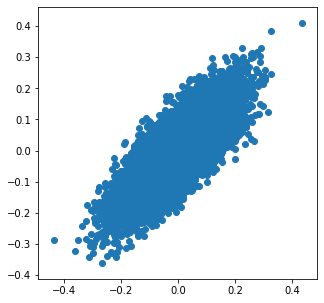

In [55]:
plt.figure(figsize=(5,5))
# plt.scatter(u1, u2)
plt.scatter(rs, rf)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

(0, 0.1)

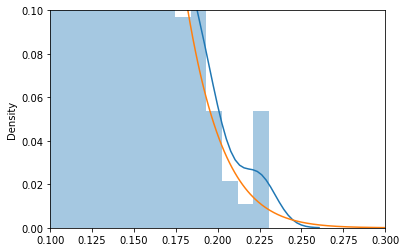

In [112]:
rh = rs-h*rf
sns.distplot(rh)
# plt.plot(y,pdf)
plt.plot(y,pdf_fn(y))

plt.xlim((0.1,0.3))
plt.ylim((0,0.1))

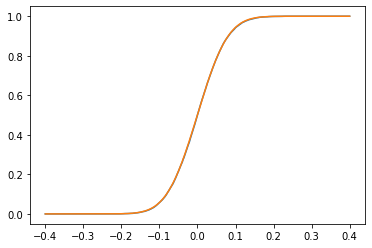

In [111]:
from statsmodels.distributions.empirical_distribution import ECDF

plt.plot(y, ECDF(rh)(y))
plt.plot(y, cdf)